In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
#import wandb
#from wandb.integration.keras import WandbMetricsLogger

os.environ["KERAS_BACKEND"] = "torch"
import keras
keras.utils.set_random_seed(812)

In [5]:
#wandb.login()

In [6]:
#run = wandb.init(
#    dir = "../results/syntheticdata/",
#    project = "series_fixedfrequency_lstm"
#)

Planted motifs: 100
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990]


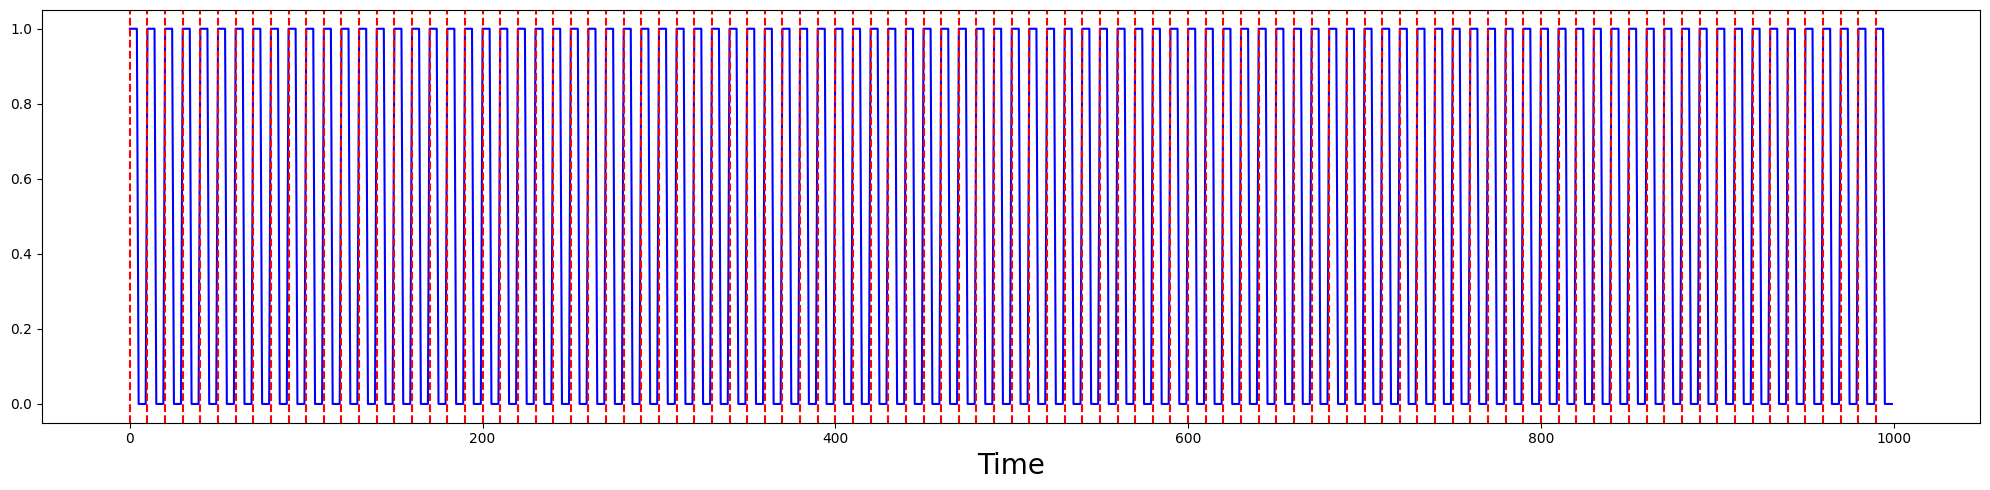

In [7]:
#fixed frequency repetitions
n = 1000
k = 1
variable_indexes = [0]
data_scenario_fixed_frequency = np.zeros(n)
#put the pattern every 1000 indexes
motif_indexes_scenario1 = []
motif_pattern = [1, 1, 1, 1, 1]
p = len(motif_pattern)
for i in range(0, n, 10):
    motif_indexes_scenario1.append(i)
    data_scenario_fixed_frequency[i:i+p] = 1

print("Planted motifs:", len(motif_indexes_scenario1))
print(motif_indexes_scenario1)

#save to file as csv
data_scenario_fixed_frequency = data_scenario_fixed_frequency.astype(int)
np.savetxt("../data/syntheticdata/scenario_fixed_frequency.csv", data_scenario_fixed_frequency, delimiter=",")
np.savetxt("../data/syntheticdata/motif_indexes_scenario_fixed_frequency.csv", motif_indexes_scenario1, delimiter=",")

#plot multivariate data using subplots in red the planted motifs
plt.figure(figsize=(20, 5))
plt.plot(data_scenario_fixed_frequency, color='blue')
for i in motif_indexes_scenario1:
    plt.axvline(x=i, color='red', linestyle='--')
plt.xlabel('Time', size=20)
plt.tight_layout()
plt.savefig("../images/data_scenario_fixed_frequency.pdf")
plt.show()


In [8]:
from keras.preprocessing.sequence import pad_sequences

def create_dataset(data,variable_indexes, lookback_period, step, forecast_period, motif_indexes):
    X1, X2, y = list(), list(),  list() # X1: data, X2: indexes of the motifs, y: distance to the next motif
    for idx in range(len(data[0]) - lookback_period - 1):
        if idx % step != 0:
            continue

        window_end_idx = idx + lookback_period
        forecast_period__end = window_end_idx + forecast_period

        #if doesnt exist more matches after the window
        if not any([window_end_idx < motif_idx for motif_idx in motif_indexes]):
            break

        motif_indexes_in_window = [motif_idx for motif_idx in motif_indexes if idx <= motif_idx <= window_end_idx]
        motif_indexes_in_forecast_period = [motif_idx for motif_idx in motif_indexes if window_end_idx < motif_idx <= forecast_period__end]

        if motif_indexes_in_forecast_period:
            next_match_in_forecast_period = motif_indexes_in_forecast_period[0]
        else:
            next_match_in_forecast_period = -1  #no match in forward window but exist in the future

        data_window = data[variable_indexes,idx:window_end_idx]

        data_y = -1 
        if next_match_in_forecast_period != -1:
            # index of the next match relative to the last match in the window
            #data_y = next_match_in_forecast_period - motif_indexes_in_window[-1] 
            # index of the next match relative to the end of the window
            data_y = next_match_in_forecast_period - window_end_idx
        
        X1.append(data_window)
        X2.append(motif_indexes_in_window) #TODO: doesnt seem to make sense to use absolute indexes
        y.append(data_y) 

    X2 = pad_sequences(X2, padding='post', value=-1, dtype=int)
    return np.array(X1), np.array(X2) , np.array(y)

In [9]:
#load data 
data_scenario_fixed_frequency = np.loadtxt("../data/syntheticdata/scenario_fixed_frequency.csv", delimiter=",")
data_scenario_fixed_frequency = data_scenario_fixed_frequency.astype(int)
data_scenario_fixed_frequency= data_scenario_fixed_frequency.reshape(1, -1)
motif_indexes_scenario_fixed_frequency = np.loadtxt("../data/syntheticdata/motif_indexes_scenario_fixed_frequency.csv", delimiter=",")
motif_indexes_scenario_fixed_frequency = motif_indexes_scenario_fixed_frequency.astype(int)


lookback_period = 50 #window size
step = 1 #step size for the sliding window
forecast_period = 25 #forward window size
#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2 , y  = create_dataset(data_scenario_fixed_frequency,variable_indexes=np.arange(1), lookback_period=lookback_period, step=step, forecast_period=forecast_period, motif_indexes=motif_indexes_scenario_fixed_frequency)
print(X1.shape, X2.shape, y.shape) # samples, features, time steps
print(X1[0,0], X2[0], y[0])

X1 = np.transpose(X1, (0, 2, 1)) #reshape input to be [samples, time steps, features]
print(X1.shape)

(940, 1, 50) (940, 6) (940,)
[1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 0 0 0 0 0] [ 0 10 20 30 40 50] 10
(940, 50, 1)


In [10]:
class BlockingTimeSeriesSplit():
  def __init__(self, n_splits):
      self.n_splits = n_splits

  def get_n_splits(self, X, y, groups):
      return self.n_splits

  def split(self, X, y=None, groups=None):
      n_samples = len(X)
      k_fold_size = n_samples // self.n_splits
      indices = np.arange(n_samples)

      margin = 0
      for i in range(self.n_splits):
          start = i * k_fold_size
          stop = start + k_fold_size
          mid = int(0.8 * (stop - start)) + start
          yield indices[start: mid], indices[mid + margin: stop]

In [11]:
#train lstm
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM, Dense, Masking
from keras import Input

import keras_tuner as kt

class MyHyperModel_LSTM(kt.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        units = hp.Choice('units', values=[10,25,50,75,100])
        model.add(LSTM(units=units, activation='tanh', return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
        model.compile(loss='mse', optimizer=Adam(learning_rate=hp_learning_rate), metrics=['mae', 'root_mean_squared_error', 'r2_score'])
        return model

In [12]:
import collections
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
import pickle


class CVTuner(kt.engine.tuner.Tuner):

    def __init__(self, *args, **kwargs):
        super(CVTuner, self).__init__(*args, **kwargs)
        # cols are metrics-val_loss, val_mae, val_rmse, val_r2
        self.metrics_history = []
        #if exists load metrics history
        if os.path.exists(os.path.join(self.project_dir, "metrics_history.npy")):
            self.metrics_history = np.load(os.path.join(self.project_dir, "metrics_history.npy"), allow_pickle=True)
        

    def run_trial(self, trial, x, y, *args, **kwargs):
        callbacks = kwargs.pop("callbacks", [])
        callbacks.append(EarlyStopping(patience=10, monitor="val_loss", start_from_epoch = 100))
        verbose = kwargs.pop("verbose", 0)
        batch_size = trial.hyperparameters.Choice('batch_size', values=[8,16,32])

        metrics = collections.defaultdict(list)
        cv = BlockingTimeSeriesSplit(n_splits=5)
        trial_metrics = np.zeros((5, 4), dtype=np.float32)
        for i, (train_indices, test_indices) in enumerate(cv.split(x)):
            #split train indices into train and validation
            mid = int(0.8 * len(train_indices))
            train_indices, val_indices = train_indices[:mid], train_indices[mid:]
            X_train, X_val, X_test = x[train_indices], x[val_indices], x[test_indices]
            y_train, y_val, y_test = y[train_indices], y[val_indices], y[test_indices]
            model = self.hypermodel.build(trial.hyperparameters)
            model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
            test_loss, test_mae, test_rmse, test_r2 = model.evaluate(X_test, y_test) 
            metrics["test_loss"].append(test_loss)
            metrics["test_mae"].append(test_mae)
            metrics["test_rmse"].append(test_rmse)
            metrics["test_r2"].append(test_r2)
            #save metrics
            for j, (_, value) in enumerate(metrics.items()):
                trial_metrics[i, j] = value[-1]

        self.save_trial_metrics(trial.trial_id, trial_metrics)
        self.metrics_history.append(trial_metrics)
        print({name: np.mean(values) for name, values in metrics.items()})
        #save cross validation metrics
        return {name: np.mean(values) for name, values in metrics.items()}

    def save_trial_metrics(self, trial_id, metrics):
        fname = os.path.join(self.get_trial_dir(trial_id), "metrics.pickle")
        with open(fname, "wb") as f:
            pickle.dump(metrics, f)
    
    def save_metrics(self):
        # aggregate metric_history into a matrix (num trials, num folds, num metrics)
        fname = os.path.join(self.project_dir, "metrics_history.npy")
        np.save(fname, np.array(self.metrics_history))
    
    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.pickle")
        with open(fname, "wb") as f:
            pickle.dump(model, f)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.pickle")
        with open(fname, "rb") as f:
            return pickle.load(f)

tuner = CVTuner(
  hypermodel=MyHyperModel_LSTM(input_shape=(X1.shape[1], X1.shape[2])),
  oracle=kt.oracles.GridSearchOracle(
    objective=kt.Objective("test_loss", "min"),
    max_trials=5),
    directory='../results/syntheticdata',
    project_name='series_fixedfrequency_lstm')
    

tuner.search(
        x=X1,
        y=y,
        verbose=0,
        callbacks=[TqdmCallback(verbose=0)],
    )
#run.finish()
tuner.save_metrics()

Reloading Tuner from ../results/syntheticdata/series_fixedfrequency_lstm/tuner0.json


0epoch [00:00, ?epoch/s]

In [13]:
tuner.results_summary()

Results summary
Results in ../results/syntheticdata/series_fixedfrequency_lstm
Showing 10 best trials
Objective(name="test_loss", direction="min")

Trial 0 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 4
Score: 4.380942416191101

Trial 1 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 8
Score: 6.205060720443726

Trial 2 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 16
Score: 7.635697937011718

Trial 3 summary
Hyperparameters:
units: 10
learning_rate: 0.001
batch_size: 32
Score: 8.016489505767822

Trial 4 summary
Hyperparameters:
units: 10
learning_rate: 0.0001
batch_size: 4
Score: 8.49449462890625


In [16]:
#get config of the best model
best_trial = tuner.oracle.get_best_trials(1)[0]

print(best_trial.hyperparameters.values)
print(best_trial.metrics.get_best_value("test_mae"))

#load best trial metrics file
cv_metrics = np.load(os.path.join(tuner.get_trial_dir(best_trial.trial_id), "metrics.pickle"), allow_pickle=True)
print(cv_metrics)


metrics = []
#train test split
mid = int(0.8 * len(np.arange(len(X1))))
X_train, X_test = X1[:mid], X1[mid:]
y_train, y_test = y[:mid], y[mid:]
model = MyHyperModel_LSTM(input_shape=(X1.shape[1],X1.shape[2])).build((best_trial.hyperparameters))
history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
          epochs=500, batch_size=best_trial.hyperparameters.values["batch_size"],
          verbose=0, callbacks=[EarlyStopping(patience=10, monitor="val_loss", start_from_epoch=100), TqdmCallback(verbose=0)])
metrics.append(model.evaluate(X_test, y_test))

keras.utils.plot_model(model, to_file="../images/best_model_lstm_casestudy_syntheticdata_fixedfrequency.png", show_shapes=True)
metrics = np.array(metrics)
print(metrics)

{'units': 10, 'learning_rate': 0.001, 'batch_size': 4}
1.4450483202934266
[[0.8210546  0.5288722  0.9061206  0.8945287 ]
 [6.278179   1.9304731  2.5056295  0.2569716 ]
 [6.184517   1.8711022  2.4868689  0.28676283]
 [6.2511277  1.9098362  2.5002255  0.26017314]
 [2.3698337  0.98495793 1.5394264  0.6955751 ]]


0epoch [00:00, ?epoch/s]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1016e-04 - mae: 0.0118 - r2_score: 1.0000 - root_mean_squared_error: 0.0145  
[[2.10033453e-04 1.17309121e-02 1.44925313e-02 9.99974251e-01]]


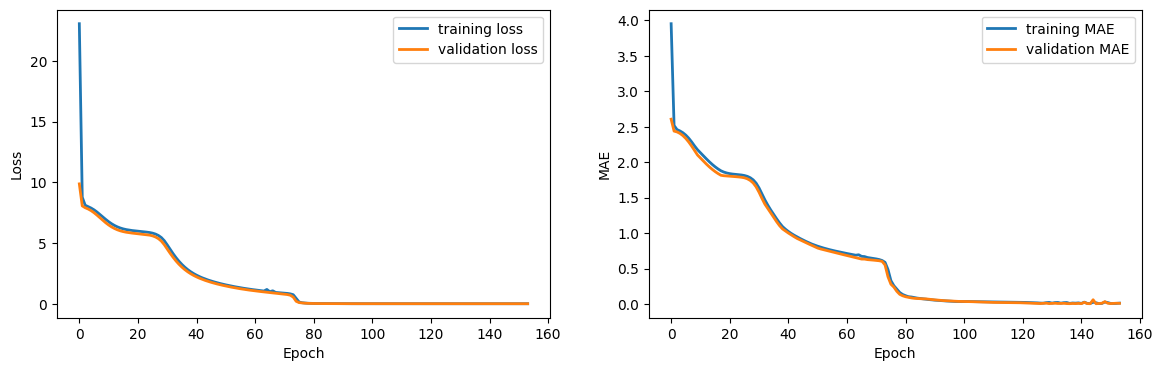

In [17]:
import pandas as pd
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs["loss"], lw=2, label='training loss')
plt.plot(logs["val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs["mae"], lw=2, label='training MAE')
plt.plot(logs["val_mae"], lw=2, label='validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend(loc='upper right')
plt.show()

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


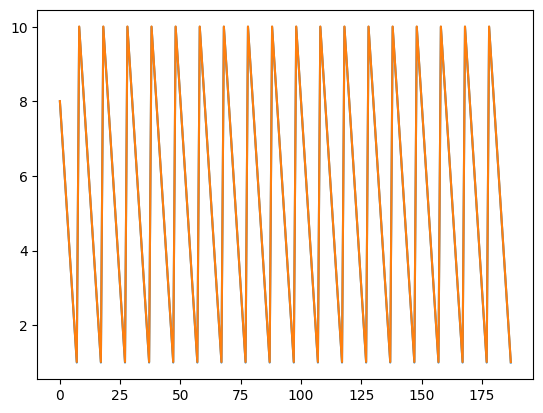

In [ ]:
#plot prediction vs true values
y_pred = model.predict(X_test)

plt.plot(y_test, label="True")
plt.plot(y_pred, label="Predicted")
plt.legend()